# Kalman Filter Model

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\BoxSpreadKalmanTreasury\root\src")
from SignalGenerator import SignalGenerator

## Box Rate

In [3]:
def get_data() -> pd.DataFrame:
    
    df_fut = SignalGenerator().get_tsy_fut()

    df_signal = (SignalGenerator().kalman_filter().query(
        "data_source == 'box'").
        drop(columns = ["data_source"]))
    
    return df_fut, df_signal

df_fut, df_signal = get_data()

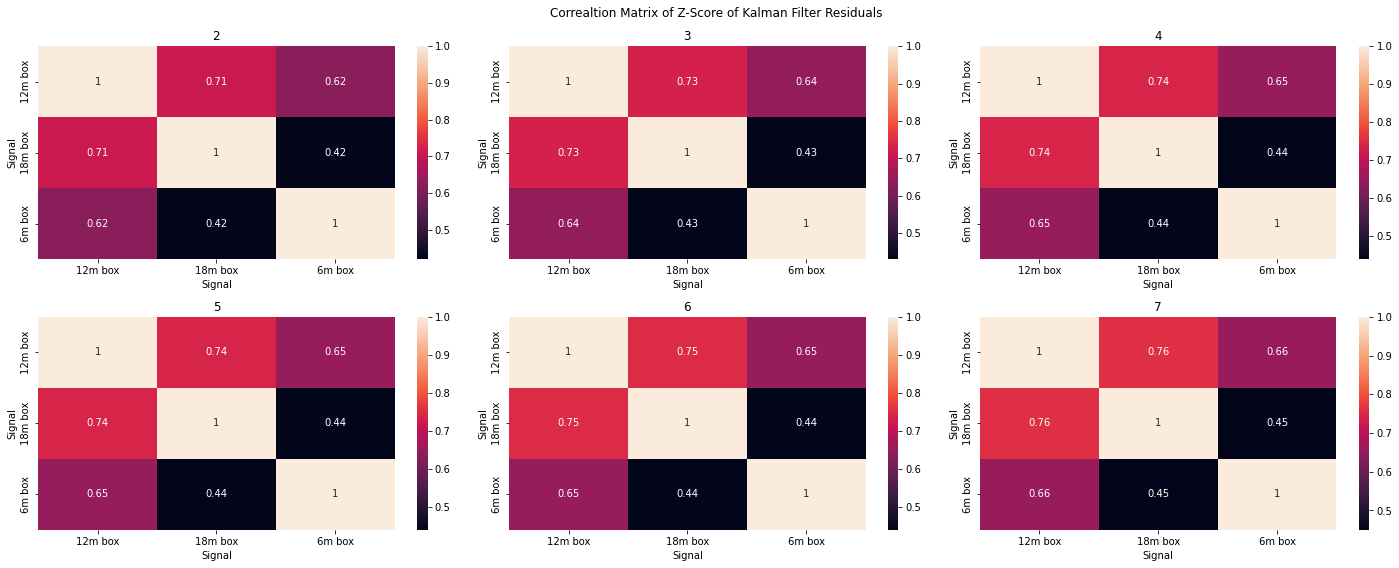

In [4]:
def plot_correlation(df_signal: pd.DataFrame) -> plt.Figure: 
    
    lookbacks = df_signal.lookback.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(lookbacks) // 2, nrows = len(lookbacks) // 3, figsize = (20,8))

    for lookback, ax in zip(lookbacks, axes.flatten()):

        df_plot = (df_signal.query(
            "lookback == @lookback")
            [["date", "group_var", "lag_zscore"]].
            rename(columns = {"group_var": "Signal"}).
            pivot(index = "date", columns = "Signal", values = "lag_zscore").
            corr().
            apply(lambda x: np.round(x, 2)))

        sns.heatmap(
            ax    = ax,
            annot = True,
            data  = df_plot)

        ax.set_title(lookback)

    fig.suptitle("Correaltion Matrix of Z-Score of Kalman Filter Residuals")
    plt.tight_layout()
    
plot_correlation(df_signal)

In [5]:
def apply_signal(df_fut: pd.DataFrame, df_signal: pd.DataFrame) -> pd.DataFrame: 
    
    df_combined = (df_fut.drop(
        columns = ["PX_LAST", "duration"]).
        merge(right = df_signal[["date", "group_var", "lookback", "lag_zscore"]], how = "inner", on = ["date"]).
        assign(
            strat_name = lambda x: x.security + " " + x.group_var + " " + x.lookback.astype(str),
            signal_rtn = lambda x: -1 * np.sign(x.lag_zscore) * x.PX_RTN,
            signal_bps = lambda x: -1 * np.sign(x.lag_zscore) * x.PX_BPS))
    
    return df_combined

df_signal_rtn = apply_signal(df_fut, df_signal)

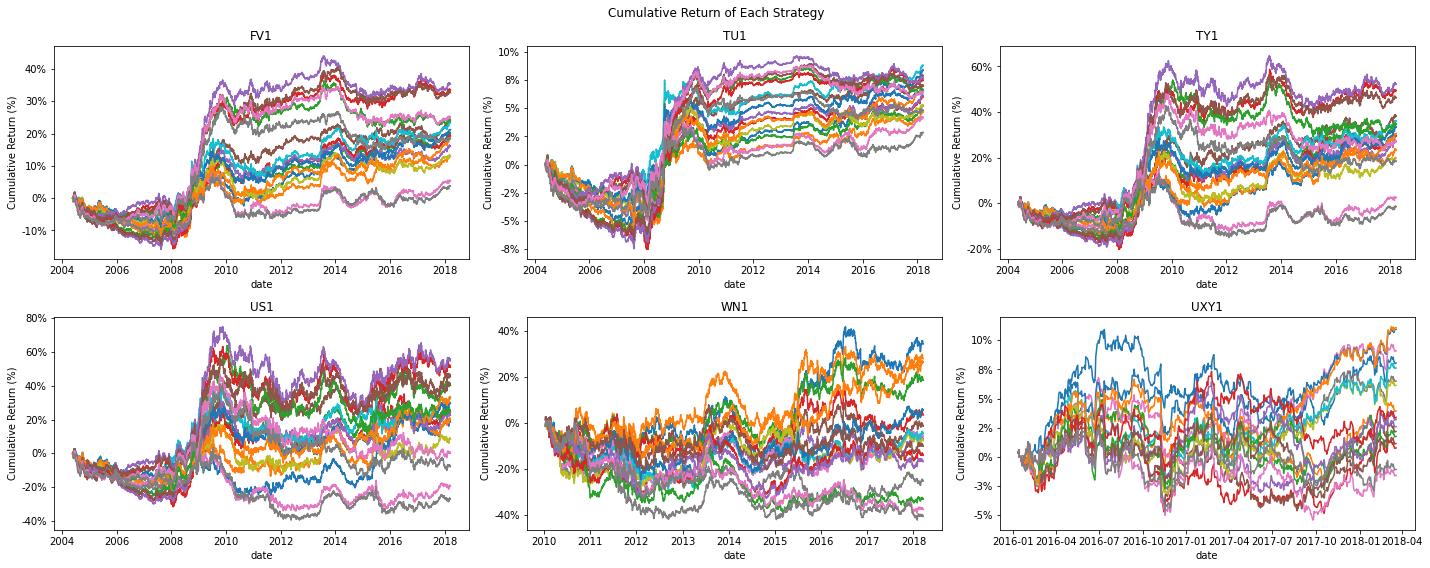

In [6]:
def plot_cumulative_returns(df_signal_rtn: pd.DataFrame) -> plt.Figure: 
    
    securities = df_signal_rtn.security.drop_duplicates().to_list()
    fig, axes  = plt.subplots(ncols = len(securities) // 2, nrows = len(securities) // 3, figsize = (20,8))

    for security, ax in zip(securities, axes.flatten()):

        (df_signal_rtn.query(
            "security == @security").
            assign(tmp_signal = lambda x: x.group_var + " " + x.lookback.astype(str))
            [["tmp_signal", "date", "signal_rtn"]].
            pivot(index = "date", columns = "tmp_signal", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                legend = False,
                ylabel = "Cumulative Return (%)",
                title  = security))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))

    fig.suptitle("Cumulative Return of Each Strategy")
    plt.tight_layout()
    
plot_cumulative_returns(df_signal_rtn)

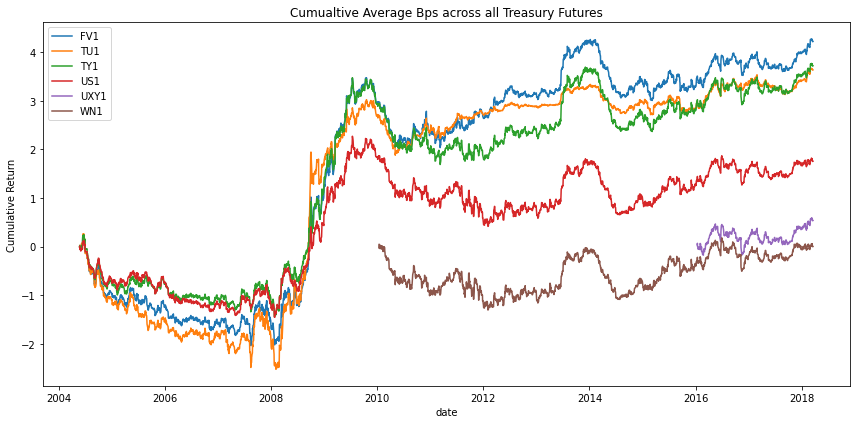

In [7]:
def plot_average_cumulative_basis_points(df_signal_rtn: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    (df_signal_rtn[
        ["date", "security", "signal_bps"]].
        groupby(["date", "security"]).
        agg("mean").
        reset_index().
        rename(columns = {"security": ""}).
        pivot(index = "date", columns = "", values = "signal_bps").
        cumsum().
        plot(
            ax     = axes,
            ylabel = "Cumulative Return",
            title  = "Cumualtive Average Bps across all Treasury Futures"))
    
    plt.tight_layout()
    
plot_average_cumulative_basis_points(df_signal_rtn)